# IMPORTS

In [1]:
import yaml
import firebase_admin
import plotly
import numpy as np
import re

import pandas as pd

import geocoder


import gspread
import httplib2
import os, io
import argparse
import auth

import unidecode

from httplib2 import Http
from oauth2client import file,client, tools
from googleapiclient import discovery
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client.service_account import ServiceAccountCredentials


from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# ABRIR LAS BBDD

## OPEN GOOGLE SHEETS

## AUTHENTIFICATION

In [3]:
SCOPES = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets.currentonly',
         'https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/presentations',
         'https://www.googleapis.com/auth/drive.scripts',
         'https://www.googleapis.com/auth/drive.appdata',
         'https://www.googleapis.com/auth/drive.metadata'
        ]
store = file.Storage('/Users/5danalfaro/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/5danalfaro/OAN/credentials/client_id.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))
sheet_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))

## GOOGLE SHETS IDS

In [4]:
spreadsheet_ids = yaml.load( open("/Users/5danalfaro/OAN/credentials/clients_sheets_parameters.yaml", "r" ),Loader=yaml.FullLoader)
#bombas de 2018, ultima version
ID1=str(spreadsheet_ids['web'])

## get sheets

In [5]:
RANGE_NAME = 'Todos'
gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=ID1, range=RANGE_NAME).execute()
df_clientes_web = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

In [6]:
#df_clientes_web

In [7]:
df_clientes_web['#Manteca']=df_clientes_web['#Manteca'].map(int)
df_clientes_web['#Bálsamo labial']=df_clientes_web['#Bálsamo labial'].map(int)
df_clientes_web['#Crema de manos']=df_clientes_web['#Crema de manos'].map(int)

### get localisation from geocoder

In [8]:
def get_coor(x):
    g=geocoder.geonames(x['Población destino']+' Spain',key='5danalfaro')
    return [float(g.lat),float(g.lng)]

In [9]:
df_clientes_web['coordinates'] = df_clientes_web.apply(lambda x: get_coor(x),axis=1)

In [10]:
df_clientes_web['latitude'] = df_clientes_web.apply(lambda x: x['coordinates'][0],axis=1)

In [11]:
df_clientes_web['longitude'] = df_clientes_web.apply(lambda x: x['coordinates'][1],axis=1)

In [12]:
l_municipios=pd.read_excel('https://www.ine.es/daco/daco42/codmun/codmun11/11codmun.xls',header=1)['NOMBRE']

In [13]:
df_clientes_web['Poblacion']=df_clientes_web['Población destino'].apply(lambda x: 
                                                                        process.extractOne(x,l_municipios)[0])

In [14]:
df_web_study=df_clientes_web[['Poblacion','latitude','longitude',
               'Fecha','#Manteca','#Bálsamo labial','#Crema de manos']]


## MAPA DE PEDIDOS

## PLOTLY

In [18]:
import chart_studio.plotly as py
import plotly.graph_objects as go

from chart_studio.plotly import plot, iplot

In [16]:
plotly_cred = yaml.load( open("/Users/5danalfaro/OAN/credentials/plotly_cred.yaml", "r" ),Loader=yaml.FullLoader)
#bombas de 2018, ultima version
plotly_cred_user=str(plotly_cred['user'])
plotly_cred_pass=str(plotly_cred['pass'])

In [19]:
py.sign_in(plotly_cred_user, plotly_cred_pass)

In [20]:
df = df_web_study.groupby('Poblacion').agg({'latitude': 'mean',
                                               'longitude': 'mean',
                                               '#Manteca': 'sum',
                                               '#Bálsamo labial':'sum',
                                               '#Crema de manos':'sum',
                                                  'Fecha':'count'}).reset_index()

In [21]:
df.columns =  ['poblacion', 'latitude', 'longitude', 'mantecas', 'balsamos',
       'cremas', 'pedidos']

In [22]:
df['ingresos']=df['mantecas']*8+df['cremas']*6+df['balsamos']*4

In [23]:
df=df.sort_values(by='ingresos')

Spain lies between latitudes 36° and 44° N, and longitudes 19° W and 5° E. Its Atlantic coast is 710 km (441 mi) long.

In [25]:
df['text'] = (df['poblacion'] + '<br>pedidos: ' + df['pedidos'].astype(str)+
            ' | mantecas: '+df['mantecas'].astype(str)+' | cremas: '+df['cremas'].astype(str)+
             ' | balsamos: '+df['balsamos'].astype(str)
             + '<br>ingresos: '+df['ingresos'].astype(str))
limits = [(0,20),(20,40),(40,80),(80,140),(140,df.ingresos.max())]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 50000

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[(df.ingresos>lim[0]) &
                (df.ingresos<=lim[1])]
    city = go.Scattergeo(
        locationmode = 'ISO-3',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['text'],
        marker = go.scattergeo.Marker(
            size = 10*df_sub['pedidos']**1.3,
            color = colors[i],
            line = go.scattergeo.marker.Line(
                width=0.5, color='rgb(40,40,40)'
            ),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = go.Layout(
        title = go.layout.Title(
            text = ('Ventas online de Nikarit | pedidos: '+str(df.pedidos.sum())+
                   '<br>Mantecas: '+str(df.mantecas.sum())+' | Cremas: '+str(df.cremas.sum())+
                   ' | Bálsamos: '+str(df.balsamos.sum())+'<br>Ingresos: '+str(df.ingresos.sum())+'€')
        ),
        showlegend = True,
        geo = go.layout.Geo(
            scope = 'europe',
            projection = go.layout.geo.Projection(
                type='mercator'
            ),
            showland = True,
            lataxis_range=[ 36, 44],
            lonaxis_range=[ -9.5, 3.3],
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
        annotations=[
            dict(
                x=1.08,
                y=1.12,
                align="right",
                valign="top",
                text='Click en las burbujas <br>para interactuar<br>(rango de ingresos)',
                showarrow=False,
                xref="paper",
                yref="paper",
                xanchor="center",
                yanchor="top"
            ),
            dict(
                x=0.08,
                y=0.15,
                align="right",
                valign="top",
                text='Tamaño de las burbuja: nº de pedidos',
                showarrow=False,
                xref="paper",
                yref="paper",
                xanchor="center",
                yanchor="bottom"
            )
    ]
    
    )

fig = go.Figure(data=cities, layout=layout)
iplot(fig, filename='clientes_nikarit_municipios')

## Histograma por fechas

In [37]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df_clientes_web['Fecha']= df_clientes_web['Fecha'].apply(
    lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

In [117]:
df_by_month=df_clientes_web.groupby('MES').agg({'#Manteca': 'sum',
                                               '#Bálsamo labial':'sum',
                                               '#Crema de manos':'sum',
                                                  'Fecha':'count'}).reset_index()

In [118]:
df_by_month.columns = ['MES', 'mantecas', 'balsamos', 'cremas', 'pedidos']

In [119]:
df_by_month['MES']=df_by_month['MES'].map(int)

In [120]:
df2 = pd.melt(df_by_month, id_vars="MES", var_name="pedido", value_name="n")

In [121]:
df_by_month['ingresos']=df_by_month['mantecas']*8+df_by_month['cremas']*6+df_by_month['balsamos']*4

In [122]:
df_by_month=df_by_month.sort_values(by='MES')

In [123]:
df=df_by_month

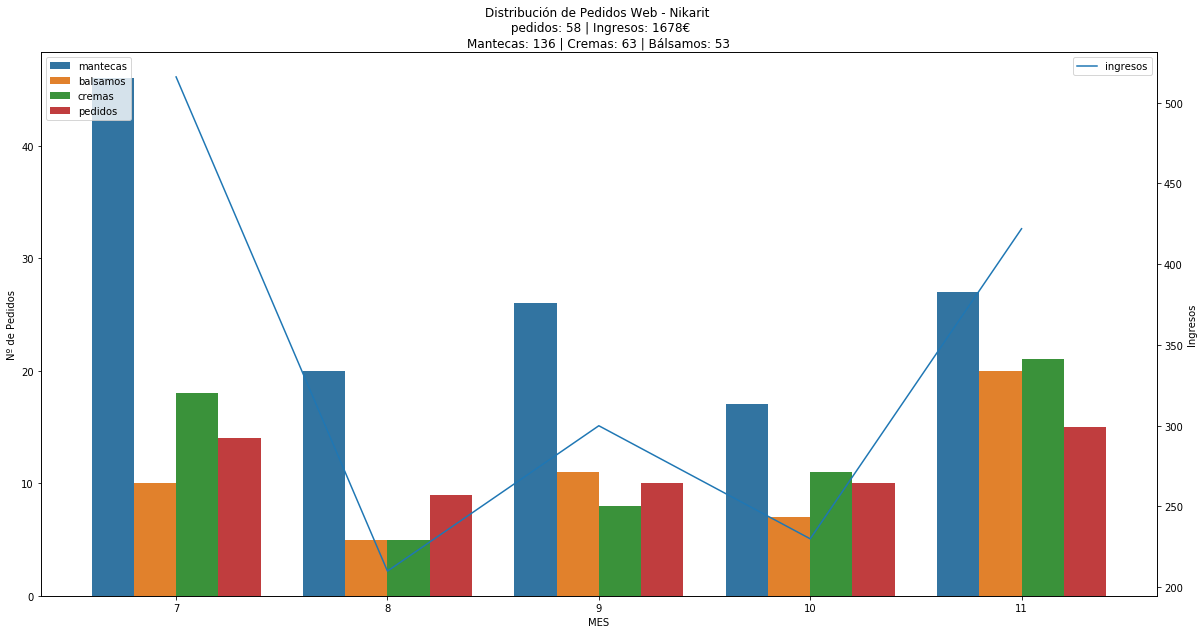

In [127]:
plt.rcParams['figure.figsize'] = 20,10
ax=sns.barplot(x='MES', y='n',hue='pedido',data=df2)
ax.set_ylabel('Nº de Pedidos')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(df_by_month.MES-7,df_by_month.ingresos)
ax2.set_ylabel('Ingresos')
ax2.legend(loc='upper right')
title=('Distribución de Pedidos Web - Nikarit \n pedidos: '+str(df.pedidos.sum())+
       ' | Ingresos: '+str(df.ingresos.sum())+'€'
                   '\nMantecas: '+str(df.mantecas.sum())+' | Cremas: '+str(df.cremas.sum())+
                   ' | Bálsamos: '+str(df.balsamos.sum()))
plt.title(title)
plt.show()

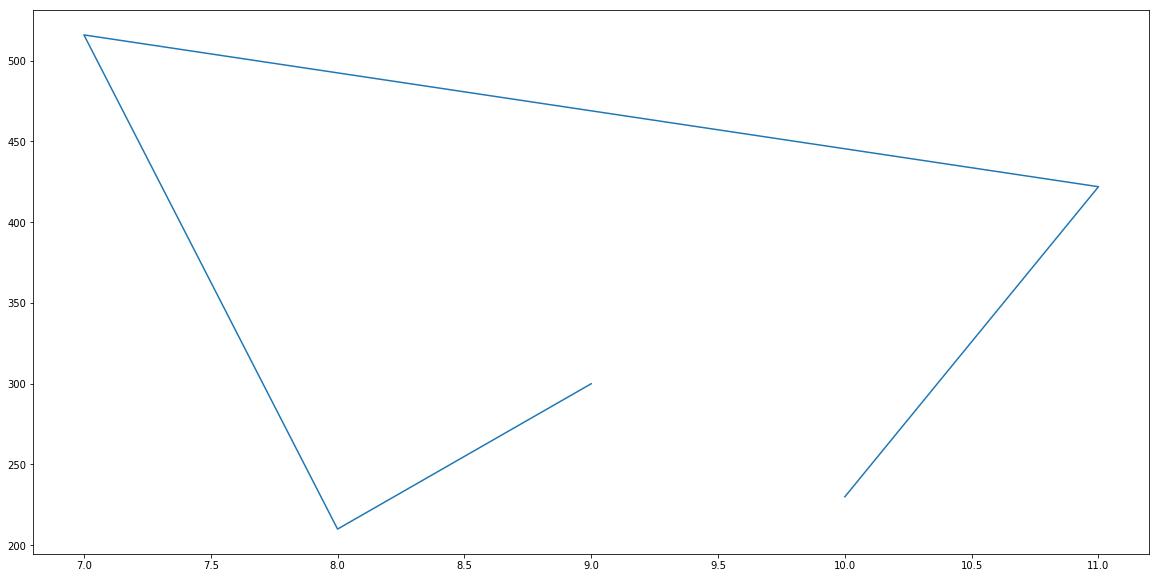

In [90]:
plt.plot(df_by_month.MES,df_by_month.ingresos)